# BaseLine

# Import Python modules

In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.utils.data as data_utils

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

2.2.0.dev20230916+cu121 0.17.0.dev20230917+cu121


# Set Training Epoch and Deep leakage epoch

In [2]:
training_epoch_num = 5
deep_leakage_epoch_num = 200

# Prepare training data and set batch size

In [3]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

dst = datasets.CIFAR100('./dataset', download=True, train=True, transform=tp)
dst_test = datasets.CIFAR100('./dataset', download=True, train=False, transform=tp)

# Detect CPU or GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

Files already downloaded and verified
Files already downloaded and verified
Running on cuda


In [4]:
batch_size = 32

train_loader = data_utils.DataLoader(dataset = dst, batch_size = batch_size, shuffle = True)
test_loader = data_utils.DataLoader(dataset = dst_test, batch_size = batch_size, shuffle = True)

print(train_loader)
print(test_loader)
print(len(dst), len(dst)/batch_size)
print(len(dst_test),len(dst_test)/batch_size)

50000 1562.5
10000 312.5


# Loss function

In [5]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

criterion = cross_entropy_for_onehot

# Define models and init weights

In [6]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

# Activating our model

In [8]:
net = LeNet().to(device)

net.apply(weights_init)

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
  )
)

# Traning our model

In [9]:
# Training Original model
mode = net.train()
Learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = Learning_rate, momentum=0.9)
loss_history = []
accuracy_history = []
loss_fn = nn.CrossEntropyLoss()

for i in range(0, training_epoch_num):
    for j, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()

        y_pred = net(x_train)

        loss = loss_fn(y_pred, y_train)

        loss.backward()

        optimizer.step()

        #Loss
        loss_history.append(loss.item())

        #Accuarcy
        number_batch = y_train.size()[0]
        _, predicted = torch.max(y_pred.data, dim = 1)
        correct_batch = (predicted == y_train).sum().item()
        accuracy_batch = 100 * correct_batch/number_batch
        accuracy_history.append(accuracy_batch)

        if(j % 500 == 0):
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(i, j , len(dst)/batch_size, loss.item(), accuracy_batch))

epoch 0 batch 0 In 1562.5 loss = 12.0499 accuracy = 0.0000%
epoch 0 batch 500 In 1562.5 loss = 4.5419 accuracy = 6.2500%
epoch 0 batch 1000 In 1562.5 loss = 4.5483 accuracy = 9.3750%
epoch 0 batch 1500 In 1562.5 loss = 4.4218 accuracy = 6.2500%
epoch 1 batch 0 In 1562.5 loss = 4.3191 accuracy = 3.1250%
epoch 1 batch 500 In 1562.5 loss = 4.0733 accuracy = 3.1250%
epoch 1 batch 1000 In 1562.5 loss = 4.0874 accuracy = 9.3750%
epoch 1 batch 1500 In 1562.5 loss = 3.9806 accuracy = 6.2500%
epoch 2 batch 0 In 1562.5 loss = 3.9111 accuracy = 9.3750%
epoch 2 batch 500 In 1562.5 loss = 3.8973 accuracy = 9.3750%
epoch 2 batch 1000 In 1562.5 loss = 3.8374 accuracy = 6.2500%
epoch 2 batch 1500 In 1562.5 loss = 4.0070 accuracy = 15.6250%
epoch 3 batch 0 In 1562.5 loss = 3.7472 accuracy = 12.5000%
epoch 3 batch 500 In 1562.5 loss = 3.3931 accuracy = 18.7500%
epoch 3 batch 1000 In 1562.5 loss = 3.9413 accuracy = 3.1250%
epoch 3 batch 1500 In 1562.5 loss = 3.6612 accuracy = 25.0000%
epoch 4 batch 0 In 

# Test our model

In [10]:
def test(): 
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = loss_fn(output, target)
        acc+=torch.sum(torch.argmax(output,dim=1)==target).item()
        sum+=len(target)
        loss_sum+=loss.item()
    print('test  acc: %.2f%%, loss: %.4f'%(100*acc/sum, loss_sum/(batch+1)))

test()

test  acc: 15.37%, loss: 3.6388


# Extract gradients from our model

In [11]:
######### honest partipant #########
img_index = 25
gt_data = dst[img_index][0].to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# plt.imshow(tt(gt_data[0].cpu()))
# plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

GT label is 84. 
Onehot label is 84.


# Generating dummy data

In [12]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# plt.imshow(tt(dummy_data[0].cpu()))
# plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Dummy label is 48.


# Deep Leakage program

In [13]:
#Training Attack model
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(deep_leakage_epoch_num):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 15.3731
10 0.4252
20 0.1153
30 0.0524
40 0.0280
50 0.0152
60 0.0079
70 0.0042
80 0.0023
90 0.0013
100 0.0007
110 0.0004
120 0.0002
130 0.0001
140 0.0001
150 0.0001
160 0.0000
170 0.0000
180 0.0000
190 0.0000


# Showing figures

Dummy label is 84.


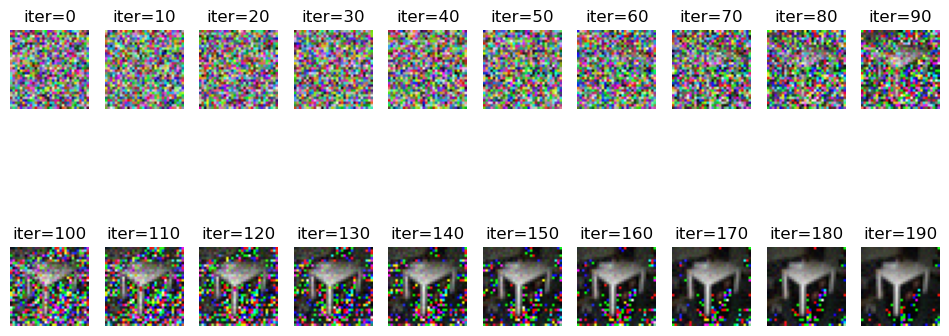

In [14]:
plt.figure(figsize=(12, 8))
for i in range(deep_leakage_epoch_num//10):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())